In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

In [2]:
device = 'cpu'

In [3]:
df = pd.read_csv('../Data/Employment_change_193902.csv')
df = df.iloc[:,1:]
df.set_index('Month', inplace=True)
print(df.shape)
# print(df.head(10))
#check if there is any na 
df.isnull().any().any()
# print(df)
# plt.plot(df['Month'], df['Total_private'])

df1 = df[['Total_private']]
# print(df1)

(1017, 3)


In [4]:
from copy import deepcopy as dc

def prepare_shifted_df(df, n_steps):
    df = dc(df)
    
    # df.set_index('Month', inplace=True)
    
    for i in range(1, n_steps + 1):
        df[f'Total_private(t-{i})'] = df['Total_private'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 2
shifted_df = prepare_shifted_df(df1, lookback)
print(shifted_df.shape)
shifted_df.head(20)
# print(type(shifted_df))

(1015, 3)


,Total_private,Total_private(t-1),Total_private(t-2)
Month,,,
1939-04-01,-186.0,179.0,164.0
1939-05-01,201.0,-186.0,179.0
1939-06-01,206.0,201.0,-186.0
1939-07-01,-99.0,206.0,201.0
1939-08-01,217.0,-99.0,206.0
1939-09-01,338.0,217.0,-99.0
1939-10-01,367.0,338.0,217.0
1939-11-01,39.0,367.0,338.0
1939-12-01,47.0,39.0,367.0


In [5]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# shifted_df_as_np.shape

# plt.plot(shifted_df_as_np[:,0])

In [6]:
shifted_df_as_np = shifted_df.to_numpy()
# shifted_df_as_np
shifted_df_as_np.shape

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
y_dir = np.sign(y)
y_dir[y_dir == -1] = 0
X = dc(np.flip(X, axis=1)) # because we want to start from the earliest time)
# X

X.shape, y_dir.shape
# print(X)
# print(y_dir)
# plt.plot(y_dir)


((1015, 2), (1015,))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_dir, test_size=0.3, shuffle = True, random_state=30)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((710, 2), (305, 2), (710,), (305,))

In [8]:
# split_index = int(len(X) * 0.7)
# # split_index
# X_train = X[:split_index]
# X_test = X[split_index:]

# y_train = y_dir[:split_index]
# y_test = y_dir[split_index:]

# X_train.shape, X_test.shape, y_train.shape, y_test.shape
# # y_test

In [9]:
#add another dimension in the end for Pytorch LSTM
# num_classes = 2
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

# y_train = y_train.reshape((-1, 1))
# y_test = y_test.reshape((-1, 1))



X_train.shape, X_test.shape, y_train.shape, y_test.shape

((710, 2, 1), (305, 2, 1), (710,), (305,))

In [10]:
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([710, 2, 1]),
 torch.Size([305, 2, 1]),
 torch.Size([710]),
 torch.Size([305]))

In [11]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset

In [12]:
#wrap dataset in data loaders to get the batches
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(test_loader))

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.dtype, y_batch.dtype)
    print(x_batch.shape, y_batch.shape)
    break

45
20
torch.float32 torch.int64
torch.Size([16, 2, 1]) torch.Size([16])


In [13]:
# rnn for classification

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='relu', batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.softmax(out)
        return out
    

In [14]:
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_stacked_layers):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_stacked_layers = num_stacked_layers

#         self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
#                             batch_first=True)
        
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         batch_size = x.size(0)
#         h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# model = LSTM(1, 4, 1)
# model.to(device)
# model

In [15]:
def train_one_epoch(dataloader, model, loss_function, optimizer):
    model.train()
    running_loss = 0.0
    
    for batch_index, batch in enumerate(dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch_index % 20 == 19:  # print every 20 batches
        #     avg_loss_across_batches = running_loss / (20 * batch_size)
        #     print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
        #                                             avg_loss_across_batches))
        #     running_loss = 0.0
    # print()
    # all_train_loss.append(running_loss / (len(train_loader) * batch_size))

In [16]:
def validate_one_epoch(dataloader, model, loss_function):
    model.eval() #evaluation mode
    running_loss = 0.0
    
    for batch_index, batch in enumerate(dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): #not calculating gradients because we're not updating model
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    
    # avg_loss_across_batches = running_loss / (len(dataloader) * batch_size)
    # print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    # print('***************************************************')
    # all_test_loss.append(running_loss / (len(test_loader) * batch_size))

In [17]:
# batch= next(iter(train_loader))
# X_batch, y_batch = batch[0].to(device), batch[1].to(device)
# print(X_batch.shape)
# print(y_batch.shape)
# output = model(X_batch)
# print(output)
# print(output.shape)
# print(y_batch.shape)
# loss_function = nn.NLLLoss()
# print(y_batch)
# loss = loss_function(output, y_batch)

In [18]:
def error_rate(y_predict, y_actual):
    assert(len(y_predict) == len(y_actual))
    max_ind_train = torch.argmax(y_predict, axis = 1)
    error = torch.sum(abs(y_actual - max_ind_train)) / len(max_ind_train)
    return error

In [19]:
input_size = 1
hidden_size = 128
num_layers = 8
num_classes = 2

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
model

RNN(
  (rnn): RNN(1, 128, num_layers=8, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [20]:
# import torchinfo

In [21]:
learning_rate = 0.002
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

all_train_error = []
all_test_error = []

num_epochs = 100
for epoch in range(num_epochs):
    
    train_one_epoch(train_loader,model,loss_function,optimizer)
    validate_one_epoch(test_loader, model, loss_function)

    with torch.no_grad():
        # predicted_train = model(X_train.to(device)).to('cpu')
        predicted_train = model(X_train)
        train_error = error_rate(predicted_train, y_train)
        all_train_error.append(train_error)

    with torch.no_grad():
        # predicted_test = model(X_test.to(device)).to('cpu')
        predicted_test = model(X_test)
        test_error = error_rate(predicted_test, y_test)
        all_test_error.append(test_error)

    if epoch % 10 == 9:
        print(f'Epoch: {epoch + 1}')
        print(f"training data error is {train_error}")
        print(f"test data error is {test_error}")
        print(len(predicted_train))
        print(len(predicted_test))

Epoch: 10
training data error is 0.23239436745643616
test data error is 0.2262295037508011
710
305
Epoch: 20
training data error is 0.23239436745643616
test data error is 0.2262295037508011
710
305
Epoch: 30
training data error is 0.23239436745643616
test data error is 0.2262295037508011
710
305
Epoch: 40
training data error is 0.13380281627178192
test data error is 0.12459016591310501
710
305
Epoch: 50
training data error is 0.13239437341690063
test data error is 0.12459016591310501
710
305
Epoch: 60
training data error is 0.1352112740278244
test data error is 0.12459016591310501
710
305
Epoch: 70
training data error is 0.1352112740278244
test data error is 0.12459016591310501
710
305
Epoch: 80
training data error is 0.1352112740278244
test data error is 0.12459016591310501
710
305
Epoch: 90
training data error is 0.1352112740278244
test data error is 0.12459016591310501
710
305
Epoch: 100
training data error is 0.1366197168827057
test data error is 0.12459016591310501
710
305


In [22]:
with torch.no_grad():
    predicted_train = model(X_train.to(device)).to('cpu')
train_error = error_rate(predicted_train, y_train)
print(f"training data error is {train_error}")

with torch.no_grad():
    predicted_test = model(X_test.to(device)).to('cpu')
test_error = error_rate(predicted_test, y_test)
print(f"test data error is {test_error}")

training data error is 0.1366197168827057
test data error is 0.12459016591310501


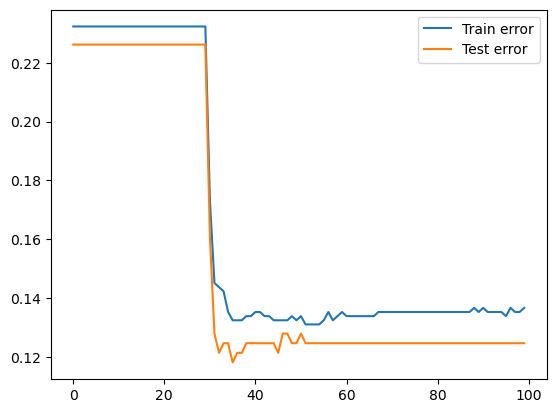

In [23]:
plt.plot(all_train_error, label = 'Train error')
plt.plot(all_test_error, label = 'Test error')
plt.legend()
plt.show()

In [24]:
# train_predictions = predicted.flatten()

# #get the original scale
# dummies = np.zeros((X_train.shape[0], lookback+1))
# dummies[:, 0] = train_predictions
# dummies = scaler.inverse_transform(dummies)

# train_predictions = dc(dummies[:, 0])
# # train_predictions

In [25]:
# dummies = np.zeros((X_train.shape[0], lookback+1))
# dummies[:, 0] = y_train.flatten()
# dummies = scaler.inverse_transform(dummies)

# new_y_train = dc(dummies[:, 0])
# # new_y_train

In [26]:
# plt.plot(y_train, label='Actual')
# plt.plot(train_predictions, label='Predicted')
# plt.xlabel('Month')
# plt.ylabel('Total private')
# plt.title('Training data')
# plt.legend()
# plt.show()

In [27]:
# test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# dummies = np.zeros((X_test.shape[0], lookback+1))
# dummies[:, 0] = test_predictions
# dummies = scaler.inverse_transform(dummies)

# test_predictions = dc(dummies[:, 0])
# # test_predictions

In [28]:
# dummies = np.zeros((X_test.shape[0], lookback+1))
# dummies[:, 0] = y_test.flatten()
# dummies = scaler.inverse_transform(dummies)

# new_y_test = dc(dummies[:, 0])
# new_y_test

In [29]:
# plt.plot(new_y_test, label='Actual')
# plt.plot(test_predictions, label='Predicted')
# plt.xlabel('Month')
# plt.ylabel('Total private')
# plt.title('Testing data')
# plt.legend()
# plt.show()